<a href="https://colab.research.google.com/github/hunn99/ML_Ganjil_2024/blob/main/Kuis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import ImageFile
import numpy as np
import pandas as pd
from cv2.gapi.ot.cpu import kernels
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from skimage.feature import local_binary_pattern
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import cv2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import random

# Load Data

In [2]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True

ImageFile.LOAD_TRUNCATED_IMAGES = True #jika ada gambar yang terpotong atau rusak dalam dataset, program tetap dapat memuatnya tanpa gagal

faces = fetch_lfw_people(min_faces_per_person=10, color=True) # Fungsi ini mengembalikan dataset yang berisi gambar wajah orang dengan label orang tersebut.
#min_faces_per_person=10 (hanya orang yang memiliki minimal 10 gambar yang dimuat.)
#color=True (data gambar dalam bentuk RGB)

# Check Faces
print(f'Total Label: {len(faces.target_names)}') #mencetak berapa orang yang memiliki minimal 10 gambar
print(f'Data dimension: {faces.images.shape}') #mencetak dimensi gambar (jumlah gambar, tinggi gambar, lebar gambar, jumlah kanal(RGB))
print(f'Images flatten dimension: {faces.data.shape}') #mencetak dimensi gambar yang sudah di flatten[3D->1D] (jumlah gambar, jumlah piksel per gambar)

Total Label: 158
Data dimension: (4324, 62, 47, 3)
Images flatten dimension: (4324, 8742)


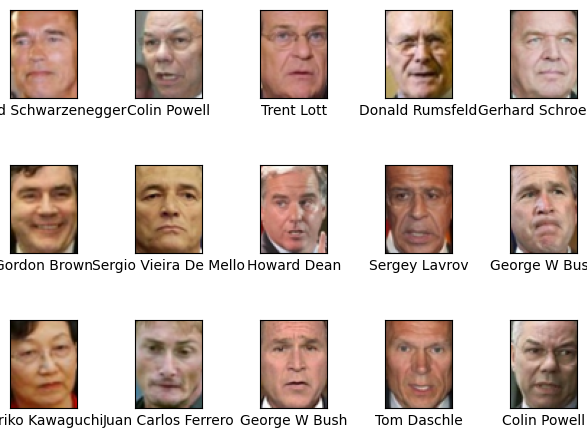

In [3]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

# PreProcessing

In [4]:
from skimage.transform import resize
import random

resized_images = [] #membuat list kosong yang akan digunakan menyimpan gambar yang telah di resize
for image, target_name in zip(faces.images, faces.target_names[faces.target]): #perulangan untuk mengambil gambar dan dan nama yang ada dalam dataset
    resized_image = resize(image, (80, 70, 3), anti_aliasing=True) # merubah ukuran gambar t=80piksel,l=70piksel,warna=3 #anti_aliasing=True (agar gambar lebih halus)
    resized_images.append((resized_image, target_name)) #menyimpan gambar yang sudah diubah ukurannya + nama gamabar ke dalam resized_images

#face.images : dataset yang berisi seluruh gambar
#faces.target : berisi angka angka yang mewakili setiap gambar(array)
#faces.target_names[faces.target] : mengambil nama dari setiap angka yang ada di face.target

# Features Extraction

In [5]:
#HOG untuk menganalisis gambar dengan mendeteksi tepi (garis atau batas) di dalam gambar dan menghitung arah (orientasi) dari tepi-tepi tersebut.
def compute_hog(image):
    # Menghitung HOG untuk gambar (dengan asumsi gambar berwarna RGB)
    hog_features = []

    # Loop untuk menghitung HOG di setiap channel warna (R, G, B)
    for channel in range(image.shape[2]):
        features, hog_image = hog(
            image[:, :, channel],
            pixels_per_cell=(8, 8),  #Setiap cell terdiri dari 8x8 piksel. HOG akan menghitung gradien di dalam setiap cell.
            cells_per_block=(2, 2),  #Setiap blok terdiri dari 2x2 cell. untuk normalisasi blok, membuat fitur lebih tahan terhadap perubahan cahaya.
            orientations=9,          #Gradien dalam setiap cell dipecah menjadi 9 orientasi arah (misalnya, 0°, 20°, 40°, dan seterusnya) untuk menangkap arah tepi.
            visualize=True,          # Mengembalikan juga gambar HOG
            block_norm='L2-Hys'      #Metode normalisasi yang membantu membuat fitur lebih stabil terhadap variasi kontras atau perubahan intensitas cahaya.
        )
        hog_features.append(features)

    return hog_features

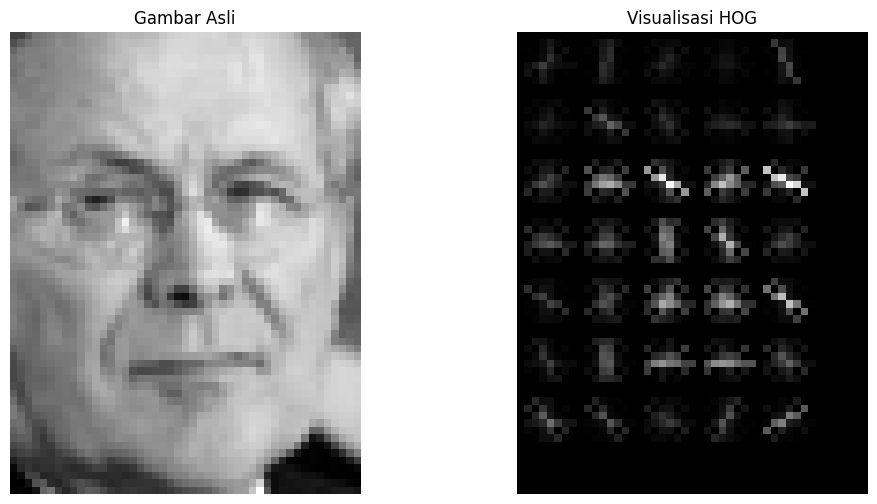

In [6]:
#VISUALISASI HOG
from skimage.feature import hog
from skimage import color
import matplotlib.pyplot as plt

# Mengubah gambar ke grayscale
gray_image = color.rgb2gray(image)

# Menghitung HOG dan mendapatkan gambar visualisasi
features, hog_image = hog(gray_image, visualize=True)

# Menampilkan gambar asli dan HOG
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(gray_image, cmap=plt.cm.gray)
ax1.set_title('Gambar Asli')

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Visualisasi HOG')

plt.show()

In [7]:
img = np.array([img for img, name in resized_images]) #membuat sebuah array NumPy yang berisi gambar-gambar dari list resized_images yang gambarnya sudah di resized
name = np.array([name for img, name in resized_images]) #untuk mengambil nama dari setiap gambar.

X = np.array([compute_hog(image) for image in img])#berisi fitur HOG untuk setiap gambar dalam bentuk array NumPy.

print(f"Feature matrix X shape: {X.shape}") # (jumlah gambar, jumlah kanal, jumlah HOG)

Feature matrix X shape: (4324, 3, 2268)


In [8]:
sample = X.shape[0] #menyimpan jumlah gambar
channels = X.shape[1] #menyimpan jumlah kanal
hog_channel = X.shape[2] #menyimpan jumlah HOG

X = X.reshape(sample, channels*hog_channel) #mereshape array x menjadi 2 dimensi dan menghitung total fitur HOG untuk semua kanal.
print(f"Feature matrix X shape: {X.shape}")
X = np.concatenate((X, X), axis=0) #menggabungkan x dengan dirinya sendiri
y = np.concatenate((name, name), axis=0) #menggabungkan name dengan dirinya sendiri
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) #menghitung mean dan standard deviation dari X

print(sample)
print(channels)
print(X)
print(y)

Feature matrix X shape: (4324, 6804)
4324
3
[[0.44427153 0.44427153 0.04605126 ... 0.07751586 0.03687577 0.11105555]
 [0.47913775 0.47913775 0.         ... 0.01751079 0.00319148 0.00113231]
 [0.31717935 0.31717935 0.08360862 ... 0.02988866 0.02493798 0.0470523 ]
 ...
 [0.28221187 0.30189767 0.30189767 ... 0.02930305 0.12947848 0.18412922]
 [0.13309874 0.10825901 0.29536095 ... 0.21075913 0.30894884 0.30894884]
 [0.2850491  0.2850491  0.2850491  ... 0.04391874 0.00766002 0.0068082 ]]
['Jacques Chirac' 'Abdullah Gul' 'Serena Williams' ...
 'Mark Philippoussis' 'Sergio Vieira De Mello' 'Donald Rumsfeld']


# Build Model

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
#membagi data set menjadi dua yaitu data train dan data test
#random_state=42 default nilai yang populer digunakan
#stratify=y agar data y tetap stabil
#y=label atau target dari dataset, yang merupakan nilai yang ingin diprediksi oleh model.

In [10]:
from sklearn.pipeline import make_pipeline


pipeline = make_pipeline( # fungsi yang membantu membuat rangkaian proses atau langkah-langkah pemrosesan data dan pelatihan model secara berurutan.
    StandardScaler(), #menormalkan/menstandarisasi data
    PCA(n_components=150),#mengurangi dimensi data gambar menjadi 150 dimensi untuk mengurangi kompleksitas model tanpa kehilangan terlalu banyak informasi penting dari data.
    SVC(C=10, kernel='rbf')#klasifikasi data, kernel='linear' berarti model memisahkan data dengan garis lurus. C=0.1 mengontrol seberapa besar toleransi model terhadap kesalahan klasifikasi

)

pipeline.fit(X_train, y_train) #pipeline dilatih dengan data X_train (fitur latih) dan y_train (label latih)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=150)), ('svc', SVC(C=10))])

# Evaluation

In [11]:
train_pred = pipeline.predict(X_train) #prediksi yang dihasilkan unruk data latih
test_pred = pipeline.predict(X_test) #prediksi yang dihasilkan unruk data train

train_accuracy = accuracy_score(y_train, train_pred)#Menghitung akurasi prediksi model pada data latih (y_train dibandingkan dengan train_pred).
test_accuracy = accuracy_score(y_test, test_pred)#Menghitung akurasi prediksi model pada data uji (y_test dibandingkan dengan test_pred).

print(f"Train accuracy: {train_accuracy:.2f}")
print(f"Test accuracy: {test_accuracy:.2f}")

# Menampilkan classification report untuk data uji
print("\nClassification Report for Test Data:")
print(classification_report(y_test, test_pred))

Train accuracy: 1.00
Test accuracy: 0.94

Classification Report for Test Data:
                           precision    recall  f1-score   support

             Abdullah Gul       1.00      1.00      1.00         8
             Adrien Brody       1.00      1.00      1.00         5
         Alejandro Toledo       0.88      0.88      0.88        16
             Alvaro Uribe       1.00      1.00      1.00        14
          Amelie Mauresmo       1.00      1.00      1.00         8
             Andre Agassi       0.75      0.86      0.80        14
             Andy Roddick       1.00      1.00      1.00         6
           Angelina Jolie       0.75      0.75      0.75         8
              Ann Veneman       1.00      1.00      1.00         4
          Anna Kournikova       1.00      0.60      0.75         5
            Ari Fleischer       1.00      1.00      1.00         5
             Ariel Sharon       0.94      0.94      0.94        31
    Arnold Schwarzenegger       0.89      1.00   

# Challenge

In [12]:
# Challange
faces = fetch_lfw_people(min_faces_per_person=10, color=True)

X = faces.images  # Data citra
y = faces.target  # Label untuk wajah

Extraction Features (LOCAL BINARY PATTERN)

In [13]:
#LBP bekerja dengan membandingkan setiap piksel di dalam gambar dengan piksel tetangganya, lalu membuat pola biner (0 dan 1) berdasarkan apakah tetangga lebih terang atau lebih gelap dari piksel pusat.
# Ekstraksi fitur menggunakan LBP
def extract_lbp_features(images):
    features = [] #list kosong untuk menyimpan fitur LBP yang diekstraksi dari setiap gambar.
    for image in images:
        # Convert to grayscale
        gray_image = np.mean(image, axis=2)
        # LBP calculation
        lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
        #P=8: Menentukan jumlah piksel tetangga yang akan dibandingkan (di sini 8).
        #R=1: Jarak antara piksel pusat dan piksel tetangga (dalam hal ini 1 piksel).
        #method='uniform': Metode ini menghasilkan pola biner yang disebut "uniform", di mana jumlah transisi dari 0 ke 1 (atau sebaliknya) terbatas pada dua.
        # Flatten LBP features (2D->1D)
        features.append(lbp.flatten())
    return np.array(features)

# Extract LBP features and images
X_lbp = extract_lbp_features(X)

X = np.concatenate((X_lbp, X_lbp), axis=0)
y = np.concatenate((y, y), axis=0)

print(f"Feature matrix X shape: {X.shape}")
print(f"Label matrix y shape: {y.shape}")

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Feature matrix X shape: (8648, 2914)
Label matrix y shape: (8648,)


Build Model (Random Forest)

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Reduksi dimensi menggunakan PCA (tanpa StandardScaler)
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Model 1: Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)
y_pred_rf = rf_model.predict(X_test_pca)

Evaluation

In [17]:
train_accuracy = accuracy_score(y_train, rf_model.predict(X_train_pca))
test_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Train accuracy: {train_accuracy:.2f}")
print(f"Test accuracy: {test_accuracy:.2f}")

# Menampilkan classification report untuk data uji
print("\nClassification Report for Test Data:")
print(classification_report(y_test, y_pred_rf))

Train accuracy: 1.00
Test accuracy: 0.84

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      0.75      0.86        16
           3       1.00      0.86      0.92        14
           4       1.00      0.67      0.80         6
           5       1.00      0.57      0.73        14
           6       1.00      0.50      0.67         8
           7       1.00      0.71      0.83         7
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         5
          10       1.00      0.71      0.83         7
          11       1.00      0.75      0.86        32
          12       1.00      0.82      0.90        22
          13       1.00      1.00      1.00         8
          14       1.00      0.78      0.88         9
          15       1.00      0.78      0.88         9
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
